#### Bibliotecas

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import osmnx as ox
import networkx as nx
from itertools import combinations
import os
import re
import rasterio
from rasterio.mask import mask
import shutil
import zipfile
from pathlib import Path
from pyproj import Transformer
import multiprocessing as mp
import itertools
import time
import networkx as nx
import pandas as pd

print(f'Utilizando a versão {ox.__version__} do OSMNX')

print(f'Eu tenho {mp.cpu_count()} CPUs disponíveis')

Utilizando a versão 2.0.1 do OSMNX
Eu tenho 8 CPUs disponíveis


#### Parâmetros e variáveis

In [9]:
# Caminhos e arquivo de entrada
input_zip_file = r'/Volumes/Dados_na_nuvem/Marcelo/Mestrado PTR/pct1_h_files.zip'
output_folder = r'/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/9_Dissertação/Resultados'
pesquisa_OD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Mapas-OD2017/Shape-OD2017/Zonas_2017_region.shp'
my_crs = '4326' # Verificar em EPSG.io um projeção que te dê o resultado em metros

# Parâmetros
pacote_num = 1          # Número do pacote a ser criado
bacia_nome = "Aricanduva"  # Nome da bacia
verbose = True

# Diretórios e configurações
pacote_path = os.path.join(output_folder, f"Pacote_{pacote_num:02d}")
raw_path = os.path.join(pacote_path, "Raw")
bacias_path = os.path.join(pacote_path, "Bacias", bacia_nome)
clipado_path = os.path.join(bacias_path, "Clipado") # Diretório para salvar os arquivos clipados

# Determinar os pixels acima do threshold
threshold = 70  # Valor informado em milímetros, mas convertido para metros, em função do raster. Valor obtido a partir da IC do Rodrigo.
threshold_max = 300 # Valor obtido a partir do paper da Pregnolato. Novamente, valor informado em milímetros, mas convertido para metros.

# Carregar a planilha no DataFrame
arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Tabelas-OD2017/Tab25_OD2017.xlsx'
# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, index_col=0)
# Exibir as primeiras linhas do DataFrame para verificação
#print(matriz_od_25.head())

#### Carregar os pontos OD referente a bacia

(65, 3)
EPSG:32723


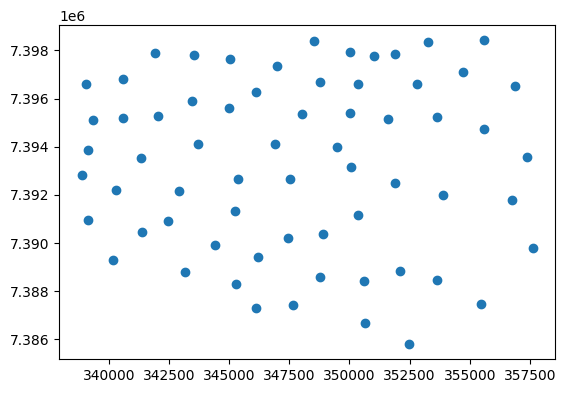

In [11]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Transformer

# Read the shapefile
gdf_OD = gpd.read_file(pesquisa_OD)

# You need to understand Geographic coordinate systems and Projected coordinate systems.
# Geographic CRS(such as 'EPSG:4326') is not suitable for measuring distance. 
# Converting degree to distance requires additional work. 
# Use a different coordinate as the warning message shows. 
# The coordinates you usually use depend on the area you want to analyze.
# It will be common to use a coordinate system based on UTM.
    
# Verifica o sistema de coordenadas
gdf_OD.crs

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_OD_utm = gdf_OD.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_OD_SP_utm = gdf_OD_utm[gdf_OD_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_OD_SP_utm["centroid"] = gdf_OD_SP_utm["geometry"].centroid

if verbose:
    mapa_centroides = gdf_OD_SP_utm['centroid'].explore()
    mapa_centroides.save('mapa_centroides_SP.html')

# Atribuição do esquema de projeção
bounding_box_baseline_utm = bounding_box_baseline.to_crs(utm_crs)

centroides_df = gpd.GeoDataFrame(gdf_OD_SP_utm[['NumeroZona', 'NomeZona']], geometry=gdf_OD_SP_utm['centroid'])
centroides_dentro = gpd.sjoin(centroides_df, bounding_box_baseline_utm, how='inner', predicate='within')

# Remover a coluna de índice criada pelo sjoin
centroides_dentro = centroides_dentro.drop(columns=['index_right'])

# Redefinir o índice
centroides_dentro = centroides_dentro.reset_index(drop=True)

if verbose:
    print(centroides_dentro.shape)
    print(centroides_dentro.crs)
    centroides_dentro.plot()

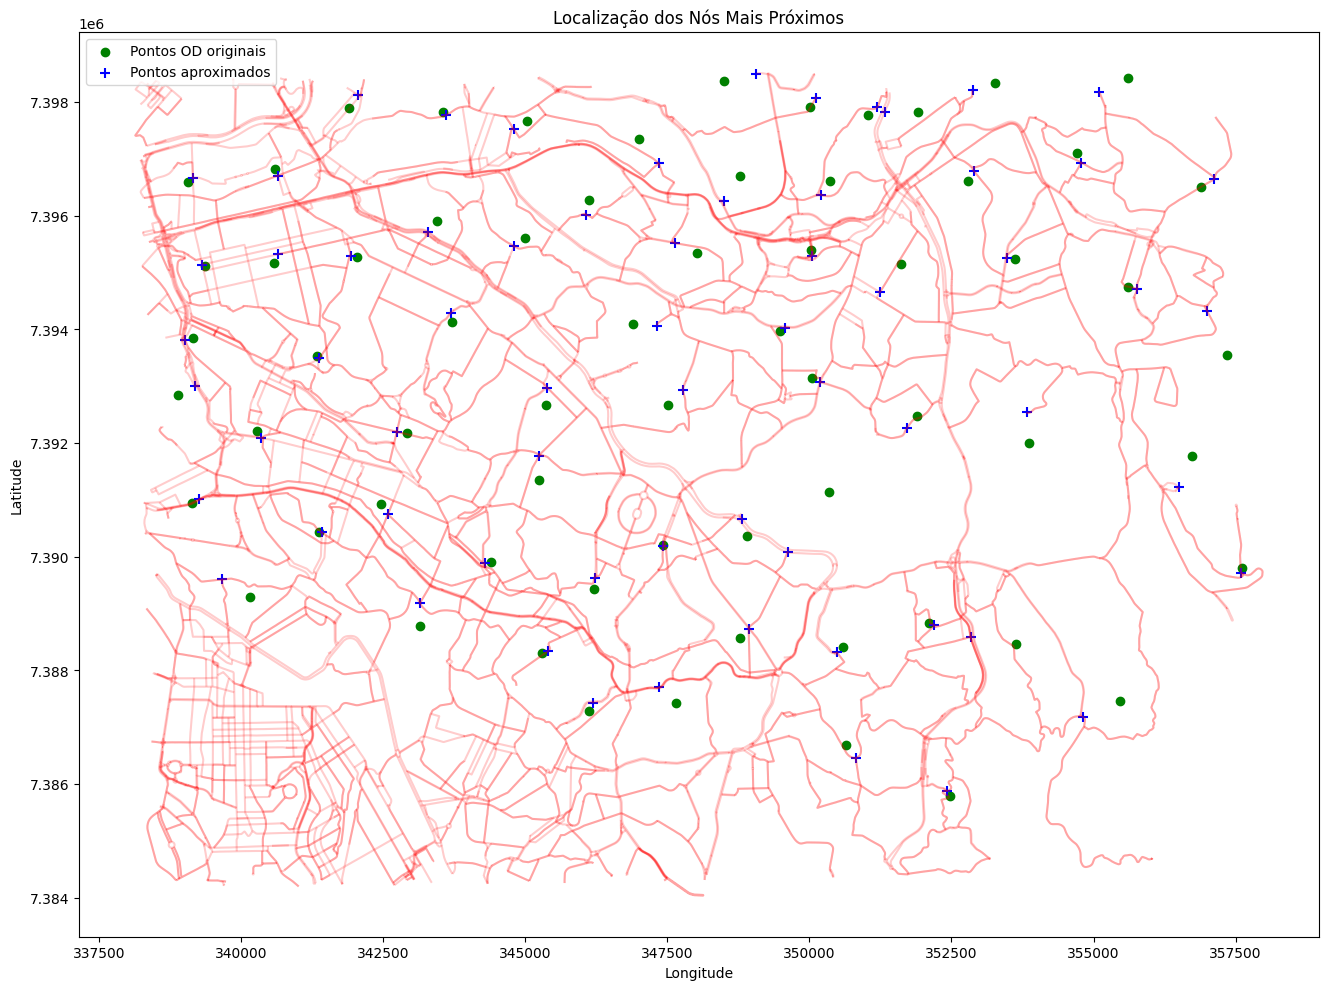

In [15]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

G_baseline_utm = ox.project_graph(G_baseline, to_crs='EPSG:32723')

# 1. Aproximar os pontos de centroides_dentro à rede
centroides_dentro['nearest_node_baseline'] = centroides_dentro['geometry'].apply(
    lambda point: ox.distance.nearest_nodes(G_baseline_utm, point.x, point.y)
)

# Função para obter coordenadas dos nós
def get_node_coords(node_id):
    node = G_baseline_utm.nodes[node_id]
    return (node['x'], node['y'])

# Adicionar coordenadas dos nós ao DataFrame
centroides_dentro['node_coords'] = centroides_dentro['nearest_node_baseline'].apply(get_node_coords)

# Separar coordenadas em colunas distintas
centroides_dentro[['node_x', 'node_y']] = pd.DataFrame(centroides_dentro['node_coords'].tolist(), index=centroides_dentro.index)

# Criar geometria dos pontos para o novo GeoDataFrame
geometry = [Point(xy) for xy in zip(centroides_dentro['node_x'], centroides_dentro['node_y'])]

# Criar o GeoDataFrame
gdf_nos_aproximados = gpd.GeoDataFrame(centroides_dentro, geometry=geometry)

# Atribuição do esquema de projeção
edges_baseline_utm = edges_baseline.to_crs(utm_crs)
gdf_nos_aproximados_utm = gdf_nos_aproximados.to_crs(utm_crs)

# Verificação gráfica do resultado
base2 = centroides_dentro.plot(color='green', figsize=(16,16), label='Pontos OD originais')

edges_baseline_utm.plot(ax=base2, color='red', alpha=0.2)

gdf_nos_aproximados.plot(ax=base2, marker='+', color='blue', markersize=50, label='Pontos aproximados')
plt.title('Localização dos Nós Mais Próximos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

#### Funções de apoio

In [16]:
def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

In [18]:
def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = centroides_dentro.loc[centroides_dentro[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = centroides_dentro.loc[centroides_dentro[referencia] == node2, 'NumeroZona'].values[0]
    return od_matrix.loc[zone1, zone2]

# 2. Definição da função para encontrar o caminho mínimo
def caminho_minimo(G, source, target, weight):
    # Encontrar o caminho mais curto
    path = nx.shortest_path(G, source=source, target=target, weight=weight)
    path_cost = nx.path_weight(G, path, weight=weight)
    return path, path_cost

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

#### Carregar o grafo de um arquivo GraphML e o bounding box

In [4]:
# Carregar o grafo de um arquivo GraphML e o bounding box
try:
    G_baseline = ox.load_graphml(filepath='network_baseline_vel_updated.graphml')
    print('Grafo carregado com sucesso!')
except:
    print('Arquivo não encontrado')

try:
    bounding_box_baseline = gpd.read_file('bounding_box_bacia.json')
    print('Bounding box carregado com sucesso!')
except:
    print('Bounding box não encontrado')
    
node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

Grafo carregado com sucesso!
Bounding box carregado com sucesso!


In [19]:
# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

CRS atual do edges_baseline: epsg:4326
CRS do edges_baseline_reprojected: EPSG:31983


In [20]:
edges_baseline_reprojected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 8333 entries, (np.int64(597447), np.int64(25778775), np.int64(0)) to (np.int64(12013065742), np.int64(1269523805), np.int64(0))
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      8333 non-null   object  
 1   oneway     8333 non-null   bool    
 2   lanes      7167 non-null   object  
 3   ref        203 non-null    object  
 4   name       7047 non-null   object  
 5   highway    8333 non-null   object  
 6   maxspeed   2906 non-null   object  
 7   reversed   8333 non-null   object  
 8   length     8333 non-null   float64 
 9   geometry   8333 non-null   geometry
 10  speed_kph  8333 non-null   float64 
 11  bridge     270 non-null    object  
 12  access     37 non-null     object  
 13  tunnel     12 non-null     object  
 14  junction   263 non-null    object  
 15  est_width  38 non-null     object  
 16  width      13 non-null     object  
dt

#### Produzir novas referências de velocidade

In [21]:
# Obter a lista de arquivos TIFF no diretório
arquivos_tif = [f for f in os.listdir(clipado_path) if f.endswith(".tif")]
total_arquivos = len(arquivos_tif)  # Total de arquivos a serem processados

# Função para extrair o número que aparece depois de "h_" ou "max_"
def extrair_numero(nome):
    match = re.search(r'(?:h_|max_)(\d+)', nome)  # Captura o número após "h_" ou "max_"
    return int(match.group(1)) if match else float('inf')  # Retorna um número grande se não encontrar nada

# Ordenar a lista com base no número extraído
arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in arquivos_ordenados:
    print(arquivo)

pct1_h_2692800_clp.tif
pct1_h_2696400_clp.tif
pct1_h_2700000_clp.tif
pct1_h_2703600_clp.tif
pct1_h_2707200_clp.tif
pct1_h_2710800_clp.tif
pct1_h_2714400_clp.tif
pct1_h_2718000_clp.tif
pct1_h_2721600_clp.tif
pct1_h_2725200_clp.tif
pct1_h_2728800_clp.tif
pct1_h_2732400_clp.tif
pct1_h_2736000_clp.tif
pct1_h_2739600_clp.tif
pct1_h_2743200_clp.tif
pct1_h_2746800_clp.tif
pct1_h_2750400_clp.tif
pct1_h_2754000_clp.tif
pct1_h_2757600_clp.tif
pct1_h_2761200_clp.tif
pct1_h_2764800_clp.tif
pct1_h_2768400_clp.tif
pct1_h_max_2768400_clp.tif


In [22]:
# Verificar que as colunas não estão presentes no GDF
edges_baseline_reprojected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 8333 entries, (np.int64(597447), np.int64(25778775), np.int64(0)) to (np.int64(12013065742), np.int64(1269523805), np.int64(0))
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      8333 non-null   object  
 1   oneway     8333 non-null   bool    
 2   lanes      7167 non-null   object  
 3   ref        203 non-null    object  
 4   name       7047 non-null   object  
 5   highway    8333 non-null   object  
 6   maxspeed   2906 non-null   object  
 7   reversed   8333 non-null   object  
 8   length     8333 non-null   float64 
 9   geometry   8333 non-null   geometry
 10  speed_kph  8333 non-null   float64 
 11  bridge     270 non-null    object  
 12  access     37 non-null     object  
 13  tunnel     12 non-null     object  
 14  junction   263 non-null    object  
 15  est_width  38 non-null     object  
 16  width      13 non-null     object  
dt